# Controled sample for z-phot using TPz

<span style="font-size:0.5cm;">
Author: Iago Lopes <br>
Email: iagolops2012@gmail.com<br><br>

</span>


<span style="font-size:0.45cm;">
The objective of this jupyter notebook is described the process made to get photo-z's from <a href="https://academic.oup.com/mnras/article/432/2/1483/1029454">TPz</a> algorithm. For this notebook is necessary to use LIneA platform.<br>
For this analysis, we're using only VIPERS and GAMA catalogs because both are good surveys and have complementary objects. VIPERS has deeper objects whereas GAMA has wider objects.
</span> 

<span style="font-size:0.5cm;">
<br>Environment setup for running TPz. Don't use this environment to run the notebook!!<br><br>
</span>

```bash
conda create -n py2 python=2.7
source activate py2
conda install numpy healpy matplotlib scipy mpich
pip install pyfits
conda install mpi4py



In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import gaussian_kde
import os
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
db=DBBase()
schema = "des_dr2"  
tablename = "des_dr2.public_pz_training_set"

# Selecting spectroscopic data 

In this section we select the spectroscopic data cross-matched with DR2 using the query based on [bonnett et al 2016](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.94.042005) and create the color index columns.

```sql

SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4


```


In [3]:

query = 'SELECT * FROM des_dr2.public_pz_training_set WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4'


In [4]:
df_origin = db.fetchall_df(query)

In [5]:
g = df_origin['mag_auto_g_dered']
r = df_origin['mag_auto_r_dered']
i = df_origin['mag_auto_i_dered']
z = df_origin['mag_auto_z_dered']
y = df_origin['mag_auto_y_dered']

df_origin['g-r'] = g-r
df_origin['r-i'] = r-i
df_origin['i-z'] = i-z
df_origin['z-y'] = z-y


In [6]:
spec_sample = df_origin


# Separating VIPERS and GAMA

In this section we separate the data based on mag_r in 20, selecting less than 20 for GAMA and more than 20 for VIPERS. 

In [7]:
vipers_o = spec_sample[spec_sample['survey'] == 'VIPERS']
vipers = vipers_o[vipers_o['mag_auto_r_dered']>20]


gama_o = spec_sample[spec_sample['survey'] == 'GAMA']
gama = gama_o[gama_o['mag_auto_r_dered']<20]


print(f'GAMA:\nBefore mag_r cut:{len(gama_o)}\nAfter: {len(gama)}')
print(f'VIPERS:\nBefore mag_r cut:{len(vipers_o)}\nAfter: {len(vipers)}')

GAMA:
Before mag_r cut:26289
After: 25989
VIPERS:
Before mag_r cut:44713
After: 44453


In [8]:
# removing 99 values
bands = ['mag_auto_g_dered','mag_auto_r_dered','mag_auto_i_dered','mag_auto_z_dered','mag_auto_y_dered']

vipers = vipers[~vipers[bands].eq(99).any(axis=1)]
gama = gama[~gama[bands].eq(99).any(axis=1)]

# Analyzing the data

Plots to caraterize and study both samples.

## Functions

### Saving data

In [9]:
def saving_data (vipers,
                 gama,
                 rand=3,
                 fraction=0.5,
                 save=False,
                 path=None):
    
    '''
    Function to separate two catalogs in training/validation and save both samples according to TPz requirements.
    After saving it shows a histogram that you can see how representative both samples are.
    Args: 
    
    vipers: DF with the VIPERS data.
    
    
    gama: DF with the GAMA data.
    ______________________________
    
    
    Kwargs:
    
    rand: Choose the random_state.
    
    
    fraction: Choose the fraction of TRAINING data. Example: fraction=0.7, so training data will have 70% of the data and validation 30%.
    
    
    save: Choose True for save the file in the path.
    
    
    path: Insert the pathfile for the files.
    
    '''
    
    vipers_training = vipers.sample(int(len(vipers)*fraction), random_state=rand)
    gama_training = gama.sample(int(len(gama)*(1-fraction)), random_state=rand)
    
    vipers_validation = vipers.drop(vipers_training.index)
    gama_validation = gama.drop(gama_training.index)
    
    
    bins1=np.linspace(19,24,20)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(vipers_training['mag_auto_i_dered'],histtype='step',color='red',label='training',bins=bins1,density=True)
    plt.hist(vipers_validation['mag_auto_i_dered'],histtype='step',color='blue',label='validation',bins=bins1,density=True)
    plt.xlabel('i')
    plt.legend()
    
    
    plt.subplot(1,2,2)
    plt.hist(vipers_training['mag_auto_r_dered'],histtype='step',color='red',label='training',bins=bins1,density=True)
    plt.hist(vipers_validation['mag_auto_r_dered'],histtype='step',color='blue',label='validation',bins=bins1,density=True)
    plt.xlabel('r')
    plt.legend()

    plt.suptitle('VIPERS')
    plt.show()




    bins2=np.linspace(16,21,20)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(gama_training['mag_auto_i_dered'],histtype='step',color='red',label='training',bins=bins2,density=True)
    plt.hist(gama_validation['mag_auto_i_dered'],histtype='step',color='blue',label='validation',bins=bins2,density=True)
    plt.xlabel('i')
    plt.legend()


    plt.subplot(1,2,2)
    plt.hist(gama_training['mag_auto_r_dered'],histtype='step',color='red',label='training',bins=bins2,density=True)
    plt.hist(gama_validation['mag_auto_r_dered'],histtype='step',color='blue',label='validation',bins=bins2,density=True)
    plt.xlabel('r')
    plt.legend()
    
    
    plt.suptitle('GAMA')
    plt.show()
    
    print(f'VIPERS\nMax: {max(vipers["z"])} Min: {min(vipers["z"])}')
    print(f'GAMA\nMax: {max(gama["z"])} Min: {min(gama["z"])}')
    if save:
        del gama_validation['coadd_object_id'], gama_validation['survey'], gama_validation['err_z'], gama_validation['flag_survey'], gama_validation['flag_des'], gama_validation['ra'], gama_validation['dec']
        del gama_training['coadd_object_id'], gama_training['survey'], gama_training['err_z'], gama_training['flag_survey'], gama_training['flag_des'], gama_training['ra'], gama_training['dec']
    
        gama_validation.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
        gama_training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
    
        
        gama_validation['eg-r'] = gama_validation['eg']-gama_validation['er']
        gama_validation['er-i'] = gama_validation['er']-gama_validation['ei']
        gama_validation['ei-z'] = gama_validation['ei']-gama_validation['ez']
        gama_validation['ez-y'] = gama_validation['ez']-gama_validation['ey']
        gama_training['eg-r'] = gama_training['eg']-gama_training['er']
        gama_training['er-i'] = gama_training['er']-gama_training['ei']
        gama_training['ei-z'] = gama_training['ei']-gama_training['ez']
        gama_training['ez-y'] = gama_training['ez']-gama_training['ey']
    
        gama_validation.to_csv(path+'validation.control_GAMA', sep=' ', index=False)
        gama_training.to_csv(path+'training.control_GAMA', sep=' ', index=False)
    
        del vipers_validation['coadd_object_id'], vipers_validation['survey'], vipers_validation['err_z'], vipers_validation['flag_survey'], vipers_validation['flag_des'], vipers_validation['ra'], vipers_validation['dec']
        del vipers_training['coadd_object_id'], vipers_training['survey'], vipers_training['err_z'], vipers_training['flag_survey'], vipers_training['flag_des'], vipers_training['ra'], vipers_training['dec']

        vipers_validation.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
        vipers_training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

        vipers_validation['eg-r'] = vipers_validation['eg'] - vipers_validation['er']
        vipers_validation['er-i'] = vipers_validation['er'] - vipers_validation['ei']
        vipers_validation['ei-z'] = vipers_validation['ei'] - vipers_validation['ez']
        vipers_validation['ez-y'] = vipers_validation['ez'] - vipers_validation['ey']
        vipers_training['eg-r'] = vipers_training['eg'] - vipers_training['er']
        vipers_training['er-i'] = vipers_training['er'] - vipers_training['ei']
        vipers_training['ei-z'] = vipers_training['ei'] - vipers_training['ez']
        vipers_training['ez-y'] = vipers_training['ez'] - vipers_training['ey']

        vipers_validation.to_csv(path+'validation.control_VIPERS', sep=' ', index=False)
        vipers_training.to_csv(path+'training.control_VIPERS', sep=' ', index=False)

    else:
        None
    
    

### Plot errors

In [10]:
def plot_errors(catalog):
    bands = ['g', 'r', 'i', 'z',]# 'y']
    j=1
    plt.figure(figsize=[10,8])
    for i, band in enumerate(bands):

        plt.subplot(2,2,j) 
        mag = np.array(catalog[f'mag_auto_{band}_dered'])
        err = np.array(catalog[f'magerr_auto_{band}'])
        sn = 1/(10**(0.4*err)-1)
        #mask = (mag>14)&(mag<32)&(err<10)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[200,100], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ")
        plt.xlabel("mag "+band)
        plt.ylim(0,100)
        plt.xlim(17,28)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

### Plot N(z)

In [11]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code=""):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$')
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()


### Plot Z-spec x Z-phot

In [12]:
def plot_scatter(zspec,zphot,title):
    # Calcula a estimativa de densidade usando kernel
    kde = gaussian_kde([zspec, zphot])

    # Define os limites do gráfico
    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    # Cria uma grade de valores para o gráfico
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)
    plt.title(title)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

### Plot metrics

Here we have the plot_metrics and plot_metrics_weighted applying the weights calculated.

In [13]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

    # Configure os limites x comuns para todos os subplots
    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.4)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)

    plt.suptitle(title)
    plt.xlim(0,points[-1])
    # Ajuste o layout dos subplots
    plt.tight_layout()
    #plt.savefig('/home/iago.dias/IC_Photo-z/Files png/metrics.png')
    

    # Exiba a figura
    plt.show()

    
    ###################################################################### WEIGHTED ##########################################################
    
    
def plot_metrics_weight(zspec,
                        zphot,
                        w,
                        maximum,
                        title=None,
                        initial=0):
    
    
    '''   Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    w: Weights for each galaxy. Same size as zphot and zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    '''
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []
    w = np.array(w['weight'])


    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        w_bin = w[(zphot >= bin_lower) & (zphot <= bin_upper)]

        
        
        deltabias = (values_r - values_s)
        mean_bias = np.sum(w_bin*deltabias)/np.sum(w_bin)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        

        sigma = (np.sum(w_bin*(values_r-values_s-mean_bias)**2)/np.sum(w_bin))**0.5
        sigmaz.append(sigma)
    
    
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
    
    
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
    
    
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

    # Configure os limites x comuns para todos os subplots
    x_lim = (0, np.max(zphot))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Standard Deviation
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: outlier
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: Outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)

    plt.suptitle(title)
    plt.xlim(0,points[-1])
    # Ajuste o layout dos subplots
    plt.tight_layout()
   

    #plt.savefig('/home/iago.dias/IC_Photo-z/Files png/weighted_metrics.png')
    # Exiba a figura
    plt.show()


### Metrics

Function to calculate the metrics and the weighted metrics.

In [14]:
def metrics(zspec,
            zphot):
    
    '''
    Function that calculate the metrics Bias, Sigma, Sigma_68, Out2σ, Out3σ.
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    
    '''
    
    meanz = np.mean(zphot-zspec)
    sigmaz = (np.sum((zphot-zspec-meanz)**2)/len(zphot))**0.5
    s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
    sigmaz68 = s[int(len(s)*0.68)]
    fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
    fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)
    
    print(f'Mean   : {meanz}\n')
    print(f'Sigma  : {sigmaz}\n')
    print(f'Sigma68: {sigmaz68}\n')
    print(f'Out_3  : {fraction3}\n')
    print(f'Out_2  : {fraction2}')
    
    
    
    
    
def metrics_weight(zspec,zphot,weight):
    w=weight['weight']
    meanz = np.sum(w*(zphot-zspec))/np.sum(w)
    sigmaz = (np.sum(w*(zphot-zspec-meanz)**2)/np.sum(w))**0.5
    s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
    sigmaz68 = s[int(len(s)*0.68)]
    fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
    fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)
    print(f'Mean   : {meanz}\n')
    print(f'Sigma  : {sigmaz}\n')
    print(f'Sigma68: {sigmaz68}\n')
    print(f'Out_3  : {fraction3}\n')
    print(f'Out_2  : {fraction2}')

### Weighting

Here we have weighting more slow for large data and the weighting fast for small data. The choice will depend of your RAM. 

In [15]:

def weighting(n_near, 
              phot, 
              vali):
    
    '''
    Function that calculate and returns the weights for each galaxy given a validation set, photometric sample and a number of nearest neighbors. This code is based on the paper from Marcos Lima,
    Carlos Cunha and collaborators from 2008. Link: https://academic.oup.com/mnras/article/390/1/118/973414
    
    Args:
    
    n_near: Int that tells the number of nearest neighbors. This can't bigger than the training sample.
    
    phot: DataFrame with the photometric data.
    
    vali: DataFrame with the spectroscopic validation data. 
    
    ___________________________________________________________
    
    Returns: DataFrame with weights and the validation data.
    
    
    '''
    
    
    
    vali['weight'] = 0.0

    phot_data = phot[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values
    vali_data = vali[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values

    for galaxy in tqdm(range(len(vali_data))):
        diff = vali_data - vali_data[galaxy]
        dist = np.sum(diff**2, axis=1)

        nearest = np.argpartition(dist, n_near)[:n_near]
        max_dist = max(dist[nearest])

        top = vali_data[galaxy] + np.sqrt(max_dist / 5)
        bottom = vali_data[galaxy] - np.sqrt(max_dist / 5)

        n_phot = 0

        for obj in phot_data:
            condition = all(bottom <= obj) and all(obj <= top)
            if condition:
                n_phot += 1

        weight = n_phot / (n_near * len(phot))
        vali.at[vali.index[galaxy], 'weight'] = weight

    return vali




def weighting_fast(n_near, 
                   phot,
                   vali):
    '''
    Function that calculate and returns the weights for each galaxy given a validation set, photometric sample and a number of nearest neighbors. This code is based on the paper from Marcos Lima,
    Carlos Cunha and collaborators from 2008. Link: https://academic.oup.com/mnras/article/390/1/118/973414
    
    Args:
    
    n_near: Int that tells the number of nearest neighbors. This can't bigger than the training sample.
    
    phot: DataFrame with the photometric data.
    
    vali: DataFrame with the spectroscopic validation data. 
    
    ___________________________________________________________
    
    Returns: DataFrame with weights and the validation data.
    
    
    '''
    
    vali['weight'] = 0.0

    phot_data = phot[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values
    vali_data = vali[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values

    for galaxy in tqdm(range(len(vali_data))):
        diff = vali_data - vali_data[galaxy]
        dist = np.sum(diff**2, axis=1)

        nearest = np.argpartition(dist, n_near)[:n_near]
        max_dist = np.max(dist[nearest])

        top = vali_data[galaxy] + np.sqrt(max_dist / 5)
        bottom = vali_data[galaxy] - np.sqrt(max_dist / 5)

        condition = np.all((bottom <= phot_data) & (phot_data <= top), axis=1)
        n_phot = np.sum(condition)

        weight = n_phot / (n_near * len(phot))
        vali.at[vali.index[galaxy], 'weight'] = weight

    return vali

### Histogram for weighting

A funtion to see how weighting is perfoming, checking the representativeness.

In [16]:
def plot_histogram_weight(spec,phot,w):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.hist(phot['mag_auto_r'],bins=30, density=True, color='red',histtype='step',label='Photometric')
    plt.hist(spec['mag_auto_r'],bins=30,density=True, color='black', histtype='step',label='Spectroscopic')
    plt.hist(w['mag_auto_r'],bins=30,density = True,color='blue',weights=w['weight'],histtype='step',label='Spectroscopic weighted')
    plt.legend(loc=2)
    plt.xlabel('r')
    plt.ylabel('Normalized count')

    plt.subplot(1,2,2)
    plt.hist(phot['mag_auto_i'],bins=30, density=True, color='red',histtype='step',label='photometric')
    plt.hist(spec['mag_auto_i'],bins=30,density=True, color='black', histtype='step',label='spectroscopic')
    plt.hist(w['mag_auto_i'],bins=30,density = True,color='blue',weights=w['weight'],histtype='step',label='spectroscopic weighted')
    plt.xlabel('i')
    plt.ylabel('Normalized count')
    #plt.savefig('/home/iago.dias/IC_Photo-z/Files png/hist_weights.png')
    plt.show()

## Removing errors

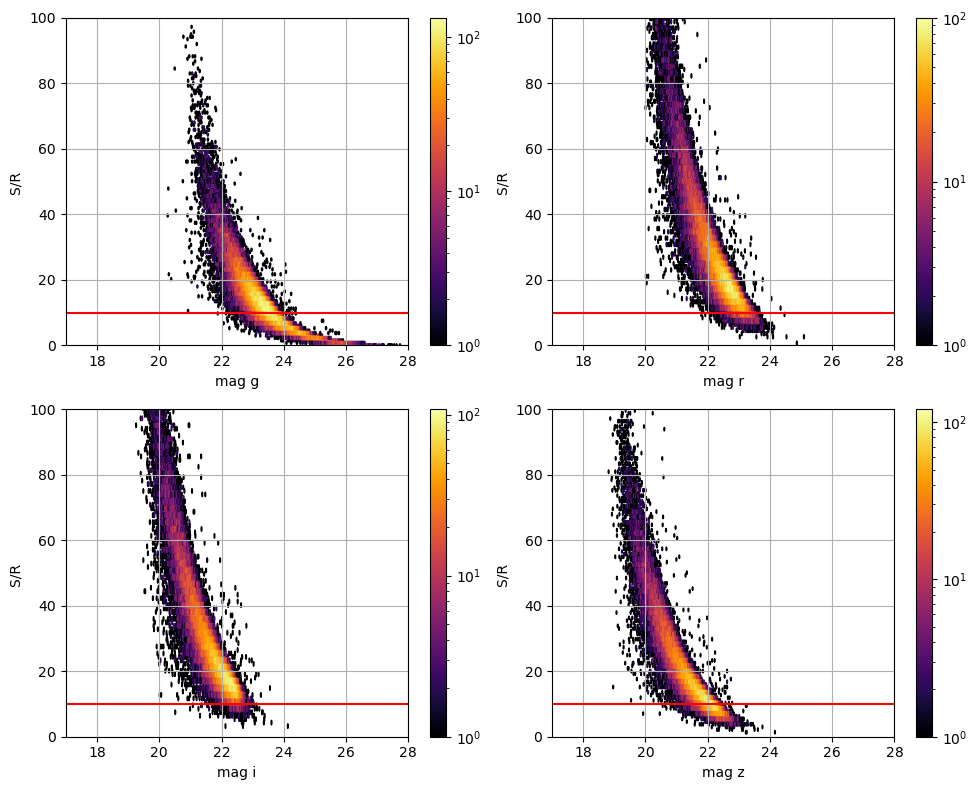

In [17]:
plot_errors(vipers) #you can change the arg for gama

Cutting errors from photometry in DR2 detection band.

In [18]:
vipers = vipers[vipers['magerr_auto_i']<0.103] 
gama = gama[gama['magerr_auto_i']<0.103]

## Redshift histogram

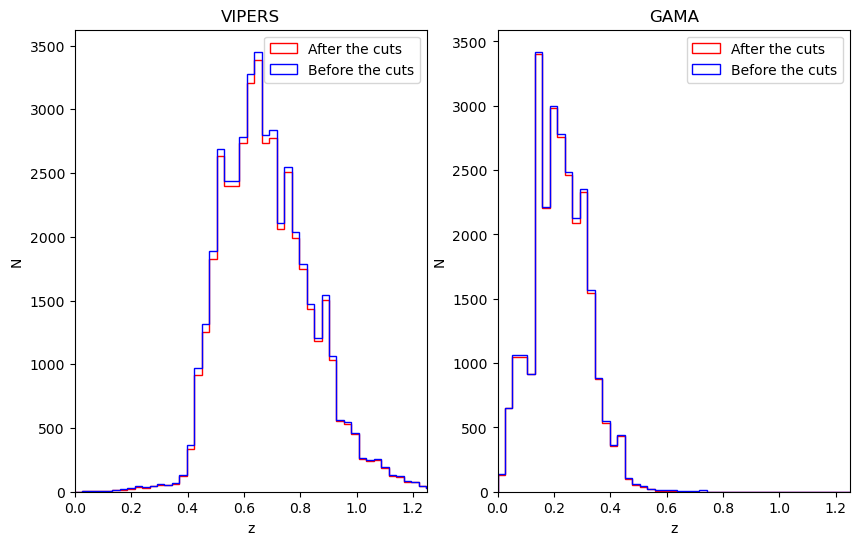

In [19]:
plt.figure(figsize=(10,6))
redshift_v_o = vipers_o['z']
redshift_v = vipers['z']
bins = np.linspace(0,1.3,50)
plt.subplot(1,2,1)
plt.hist(redshift_v, bins = bins, color = 'red',histtype='step',label='After the cuts')
plt.xlabel('z')
plt.xlim(0,1.25)
plt.ylabel('N')
plt.hist(redshift_v_o, bins =bins, color = 'blue',histtype='step',label='Before the cuts')
plt.legend()
plt.title('VIPERS')


redshift_g_o = gama_o['z']
redshift_g = gama['z']
plt.subplot(1,2,2)
plt.hist(redshift_g, bins = bins, color = 'red',histtype='step',label='After the cuts')
plt.xlabel('z')
plt.xlim(0,1.25)
plt.ylabel('N')
plt.hist(redshift_g_o, bins =bins, color = 'blue',histtype='step',label='Before the cuts')
plt.legend()
plt.title('GAMA')
plt.show()

## Mag histogram

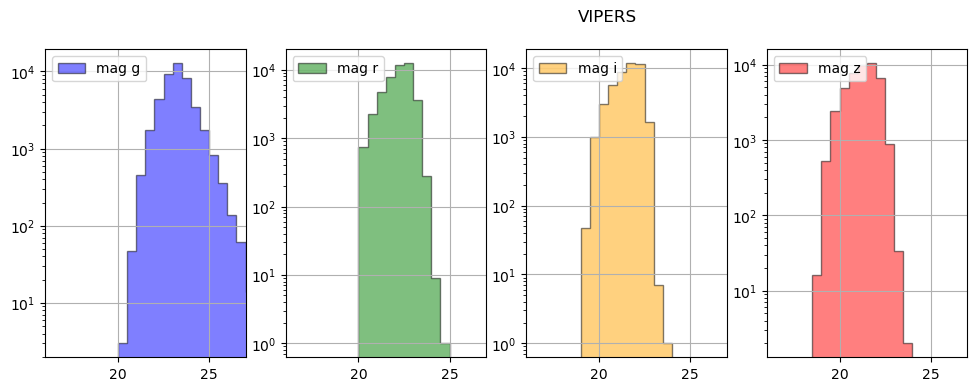

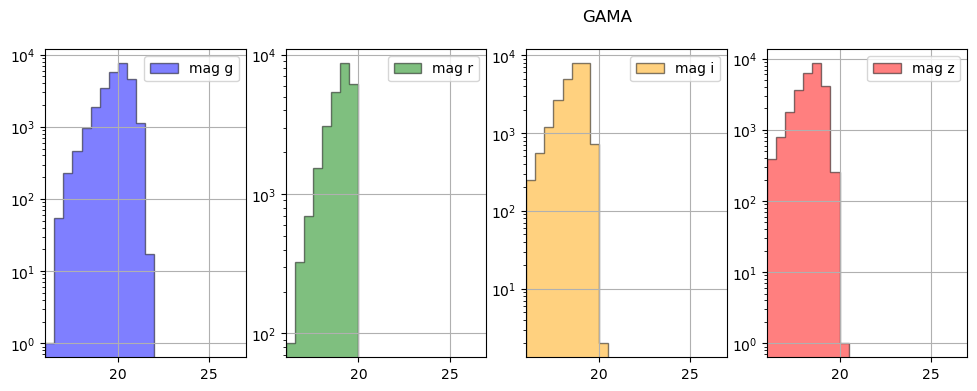

In [20]:
bands = ['g', 'r', 'i', 'z']
colors = ['blue', 'green', 'orange','red']
plt.figure(figsize=(15,4))
bins = np.linspace(9, 37, 57)
j=1
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.subplot(1,5,j)
    catalog = vipers
    plt.hist(catalog[f'mag_auto_{band}_dered'], histtype='stepfilled', bins=bins, label=f'mag {band}', alpha = 0.5, edgecolor = "black", color = color)
    plt.xlim(16,27)
    plt.yscale('log')
    plt.legend(loc=2)
    plt.grid(True)
    j+=1
plt.suptitle('VIPERS')
plt.show()


plt.figure(figsize=(15,4))
bins = np.linspace(9, 37, 57)
j=1
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.subplot(1,5,j)
    catalog = gama
    plt.hist(catalog[f'mag_auto_{band}_dered'], histtype='stepfilled', bins=bins, label=f'mag {band}', alpha = 0.5, edgecolor = "black", color = color)
    plt.xlim(16,27)
    plt.yscale('log')
    plt.legend(loc=1)
    plt.grid(True)
    j+=1
plt.suptitle('GAMA')
plt.show()

## Mag x Color

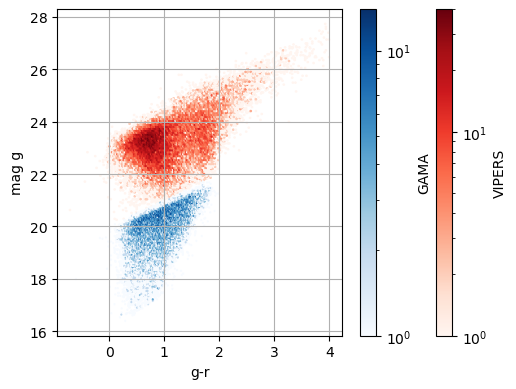

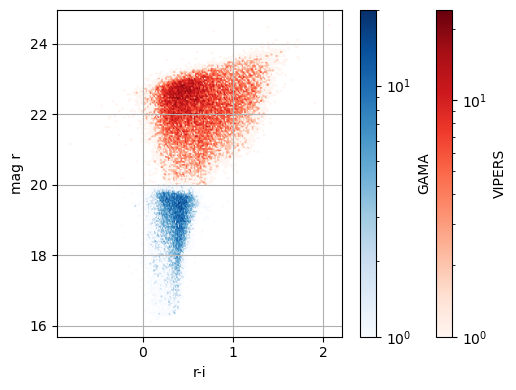

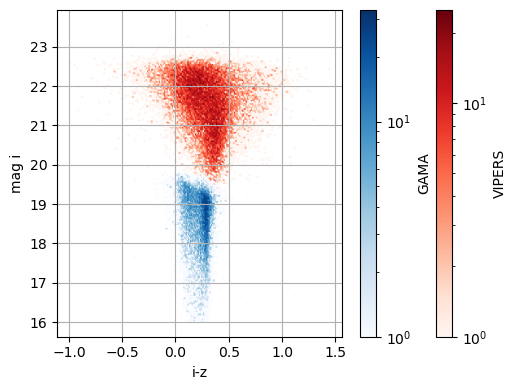

In [21]:
bands = ['g', 'r', 'i', 'z']
mag_diff = {}
for band,_band in zip(bands, bands[1::]):
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    mag_diff_v = vipers[f'mag_auto_{band}_dered']-vipers[f'mag_auto_{_band}_dered'] #for vipers
    mag_v = vipers[f'mag_auto_{band}_dered'] #for vipers
    mag_diff_g = gama[f'mag_auto_{band}_dered']-gama[f'mag_auto_{_band}_dered'] #for gama
    mag_g = gama[f'mag_auto_{band}_dered'] #for gama
                   
        
    plt.hexbin(mag_diff_v, mag_v, None, mincnt=1, cmap='Reds', gridsize=[200,100], bins='log',label='VIPERS')
    plt.colorbar(label='VIPERS')
    plt.hexbin(mag_diff_g, mag_g, None, mincnt=1, cmap='Blues', gridsize=[200,100], bins='log',label='GAMA')
    cbar = plt.colorbar(label='GAMA')
    plt.ylabel("mag "+band)
    #plt.legend()
    plt.xlabel(f"{band}-{_band}")
    plt.grid(True)
    plt.tight_layout()

## Color x Color

### g-r x r-i

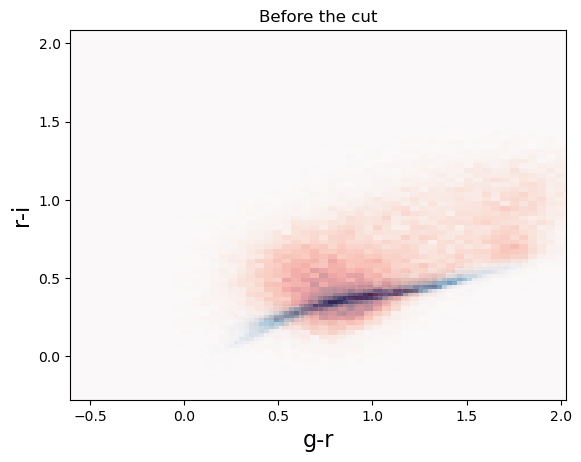

In [22]:
plt.hist2d(vipers_o['g-r'],vipers_o['r-i'],bins=100,cmap='Reds',alpha=1.0)
plt.hist2d(gama_o['g-r'],gama_o['r-i'],bins=100,cmap='Blues',alpha=0.6)
plt.xlabel('g-r', fontsize=16)
plt.ylabel('r-i', fontsize=16)
plt.title('Before the cut')
plt.show()

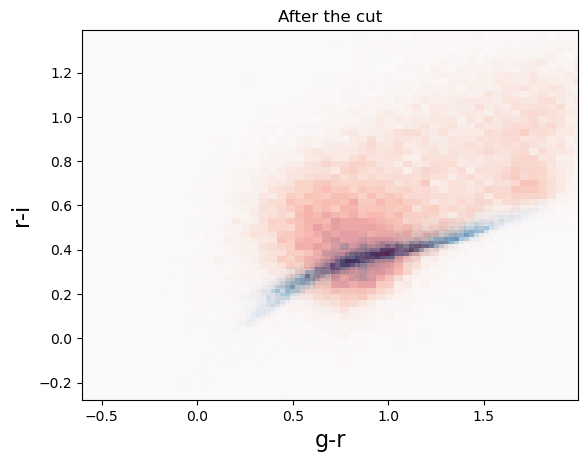

In [23]:
plt.hist2d(vipers['g-r'],vipers['r-i'],bins=100,cmap='Reds',alpha=1.0)
plt.hist2d(gama['g-r'],gama['r-i'],bins=100,cmap='Blues',alpha=0.6)
plt.xlabel('g-r', fontsize=16)
plt.ylabel('r-i', fontsize=16)
plt.title('After the cut') 
plt.show()

### r-i x i-z

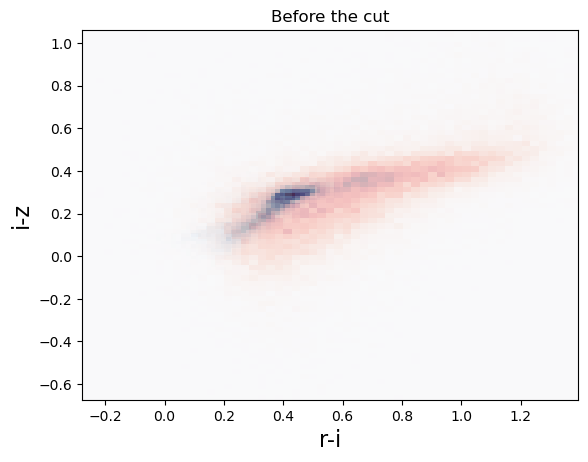

In [24]:
plt.hist2d(vipers['r-i'],vipers['i-z'],bins=100,cmap='Reds',alpha=1.0)
plt.hist2d(gama['r-i'],gama['i-z'],bins=100,cmap='Blues',alpha=0.7)
plt.xlabel('r-i', fontsize=16)
plt.ylabel('i-z', fontsize=16)
plt.title('Before the cut')
plt.show()

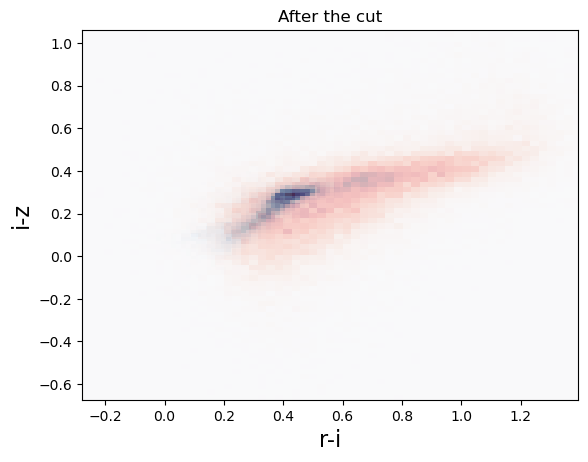

In [25]:
plt.hist2d(vipers['r-i'],vipers['i-z'],bins=100,cmap='Reds',alpha=1.0)
plt.hist2d(gama['r-i'],gama['i-z'],bins=100,cmap='Blues',alpha=0.7)
plt.xlabel('r-i', fontsize=16)
plt.ylabel('i-z', fontsize=16)
plt.title('After the cut')
plt.show()

## Looking possible filaments of cosmic web

In [26]:
red2=gama[(gama['z']>0.13)&(gama['z']<0.16)]
red3=gama[(gama['z']>0.29)&(gama['z']<0.32)]

len(red2)/len(gama)

0.13990534456885606

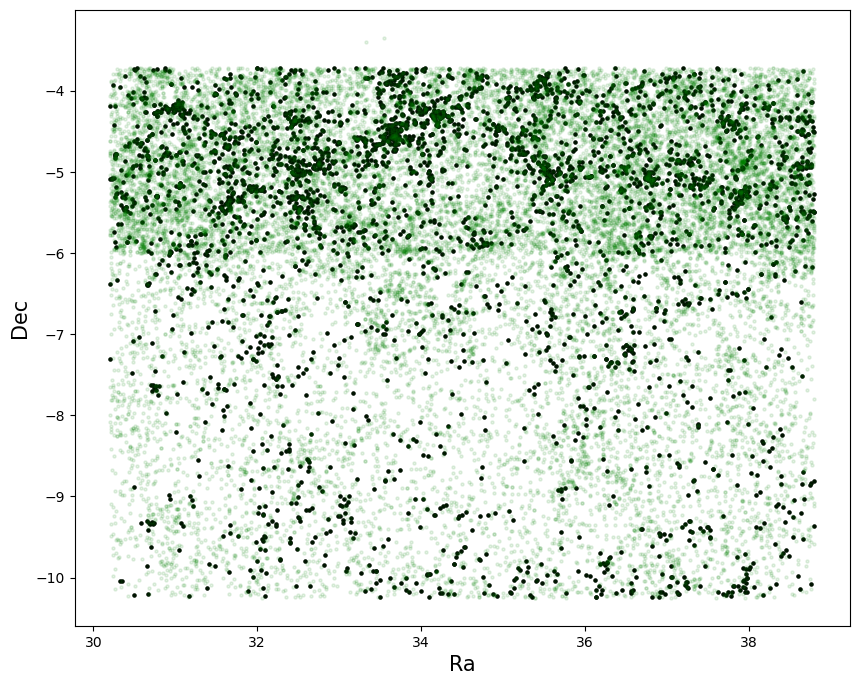

In [27]:
plt.figure(figsize=(10,8))
#plt.scatter(red3['ra'],red3['dec'],color='red',s=5)
plt.scatter(red2['ra'],red2['dec'],color='black',s=5)
plt.scatter(gama['ra'],gama['dec'],color='green',s=5,alpha=0.1)
plt.xlabel('Ra',fontsize=15)
plt.ylabel('Dec',fontsize=15)
#plt.ylim(-6,-3.5)
plt.show()

# Separating training and testing samples

In this section we split the data and checking if training and validation are representative of each other. 50% for training and 50% for validation.

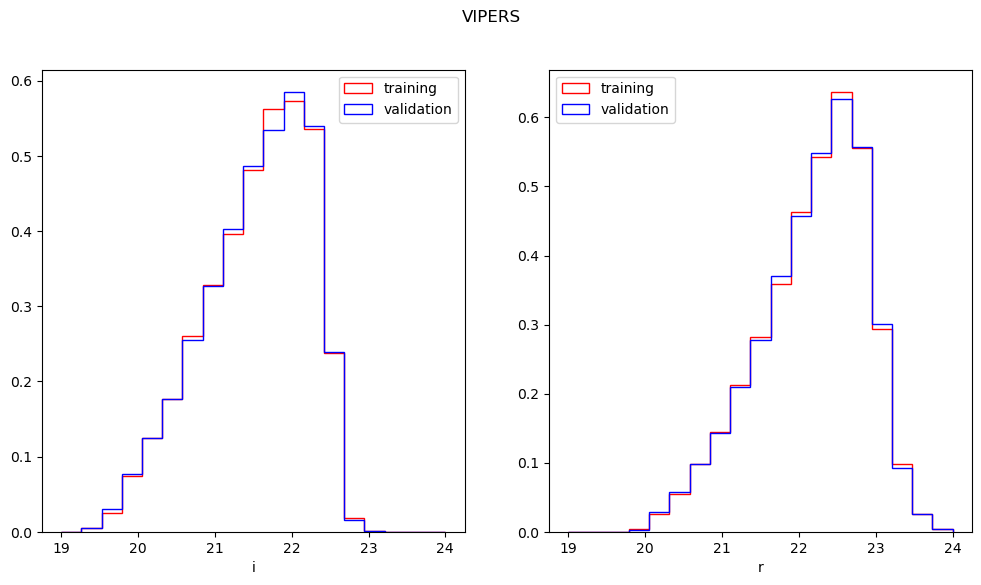

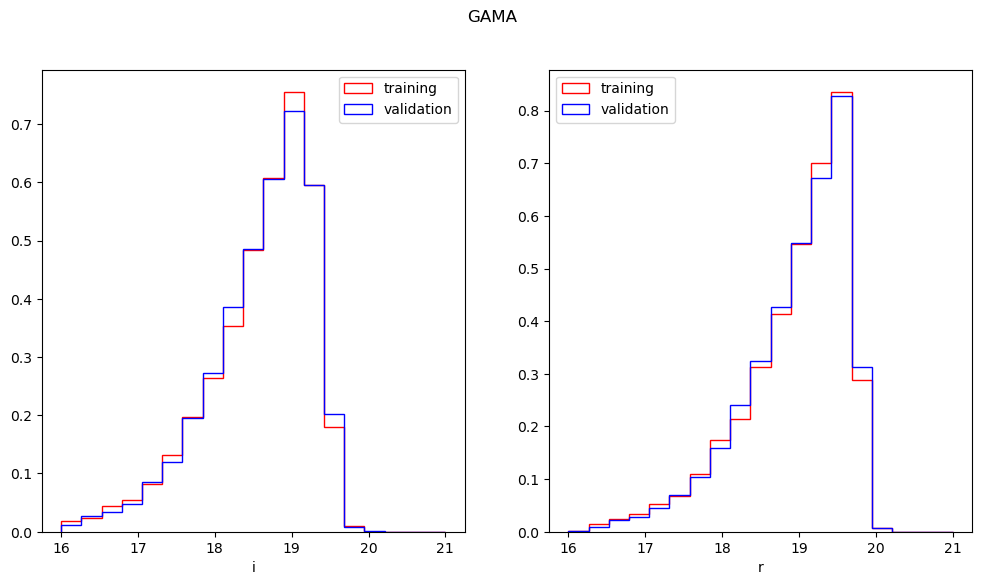

VIPERS
Max: 1.9954 Min: 0.0446
GAMA
Max: 0.732283 Min: 0.00475849


In [30]:
saving_data(vipers,gama,save=False,path='/home/iago.dias/IC_Photo-z/Iago/samples/')

# Weighting (After running TPz)

The TPz was runned in terminal !!!

In this section we calculate the weights based on technique described in [Lima, Cunha et al 2008](https://academic.oup.com/mnras/article/390/1/118/973414). 

## Spec sample for weighting

Reading a csv with the photometric sample with the same cuts as spectroscopic sample.

```sql
SELECT ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y 
FROM des_dr2.coadd_objects 
WHERE mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4 AND magerr_auto_i<0.103 ORDER BY RANDOM() LIMIT 100000;



```

In [31]:



query_dr2_spec_catalog = 'SELECT ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4 AND magerr_auto_i<0.103 ORDER BY RANDOM() LIMIT 100000; '



In [32]:
#origin = db.fetchall_df(query_dr2_spec_catalog)
#dr2_sample = origin

dr2_sample = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/samples/phot_sample_weighting_control_VIPERS_GAMA.csv',sep=' ') # data saved
dr2_sample_vipers = dr2_sample[dr2_sample['mag_auto_r']>20]
dr2_sample_gama = dr2_sample[dr2_sample['mag_auto_r']<20]

## Calculating weights VIPERS

In [33]:
column_names2 = ['z','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y','g-r','r-i','i-z','z-y','eg-r','er-i','ei-z','ez-y']

validation_vipers = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_VIPERS', sep=' ', names= column_names2, header = None, skiprows=1)



100%|██████████| 22119/22119 [00:35<00:00, 618.10it/s]


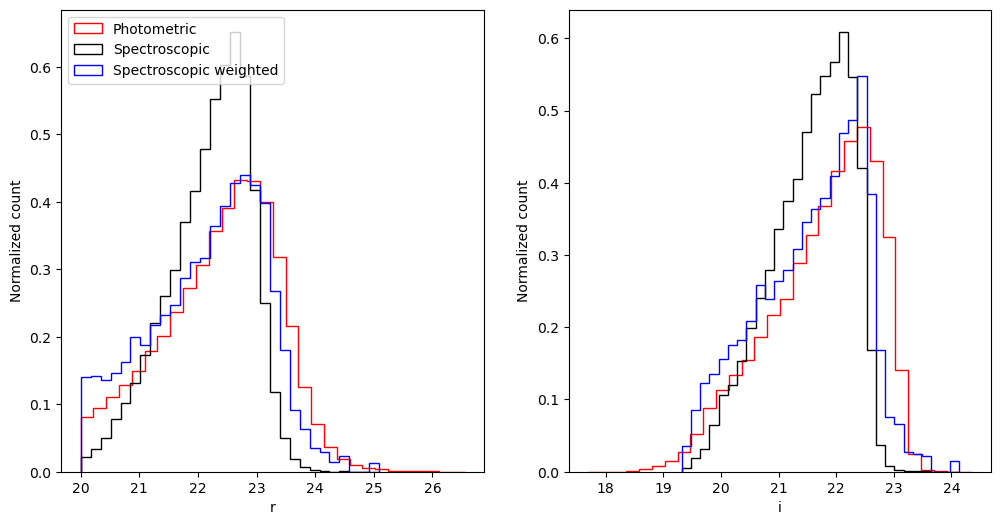

In [34]:
w_vipers = weighting_fast(50,dr2_sample_vipers,validation_vipers) #use this if it's too slow
#w = weighting(4000,test,validation) # use this if kernel's dying

plot_histogram_weight(validation_vipers,dr2_sample_vipers,w_vipers)

## Calculating weights GAMA

In [35]:
column_names2 = ['z','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y','g-r','r-i','i-z','z-y','eg-r','er-i','ei-z','ez-y']

validation_gama = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_GAMA', sep=' ', names= column_names2, header = None, skiprows=1)



100%|██████████| 12995/12995 [00:08<00:00, 1464.45it/s]


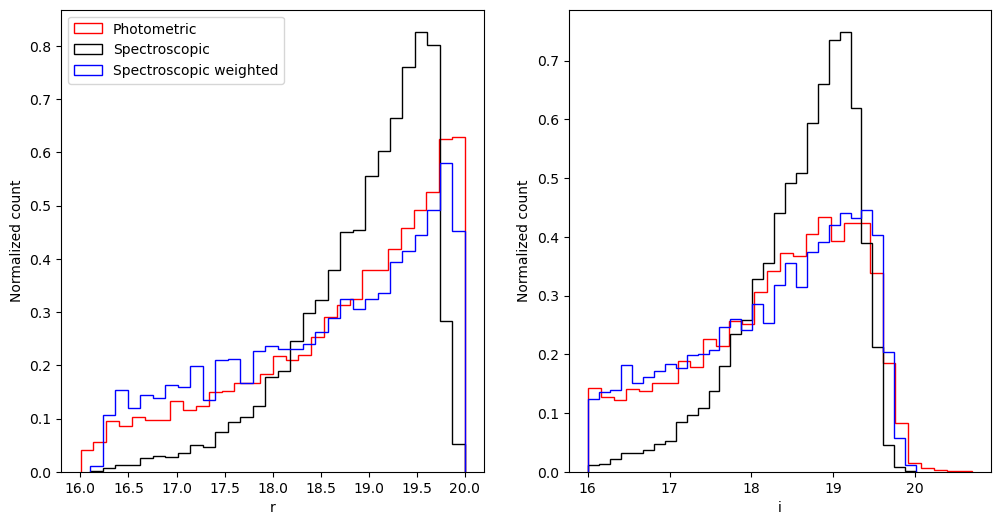

In [36]:
w_gama = weighting_fast(100,dr2_sample_gama,validation_gama) #use this if it's too slow
#w = weighting(4000,test,validation) # use this if kernel's dying

plot_histogram_weight(validation_gama,dr2_sample_gama,w_gama)

# Analyzing results

Plots with final metrics.

## VIPERS results

In [37]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df_vipers = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/results/results.control_VIPERS.0.mlz',names = column_names, header = None, skiprows =1, sep =' ')

zspec_vipers=df_vipers['ztrue']
zphot_vipers = df_vipers['zmean1']

Checking the percentage of redshift after a value. (Choose the max of plot_metrics)

In [38]:
len(zspec_vipers[zspec_vipers>1.2])/len(zspec_vipers)

0.0060581400605814

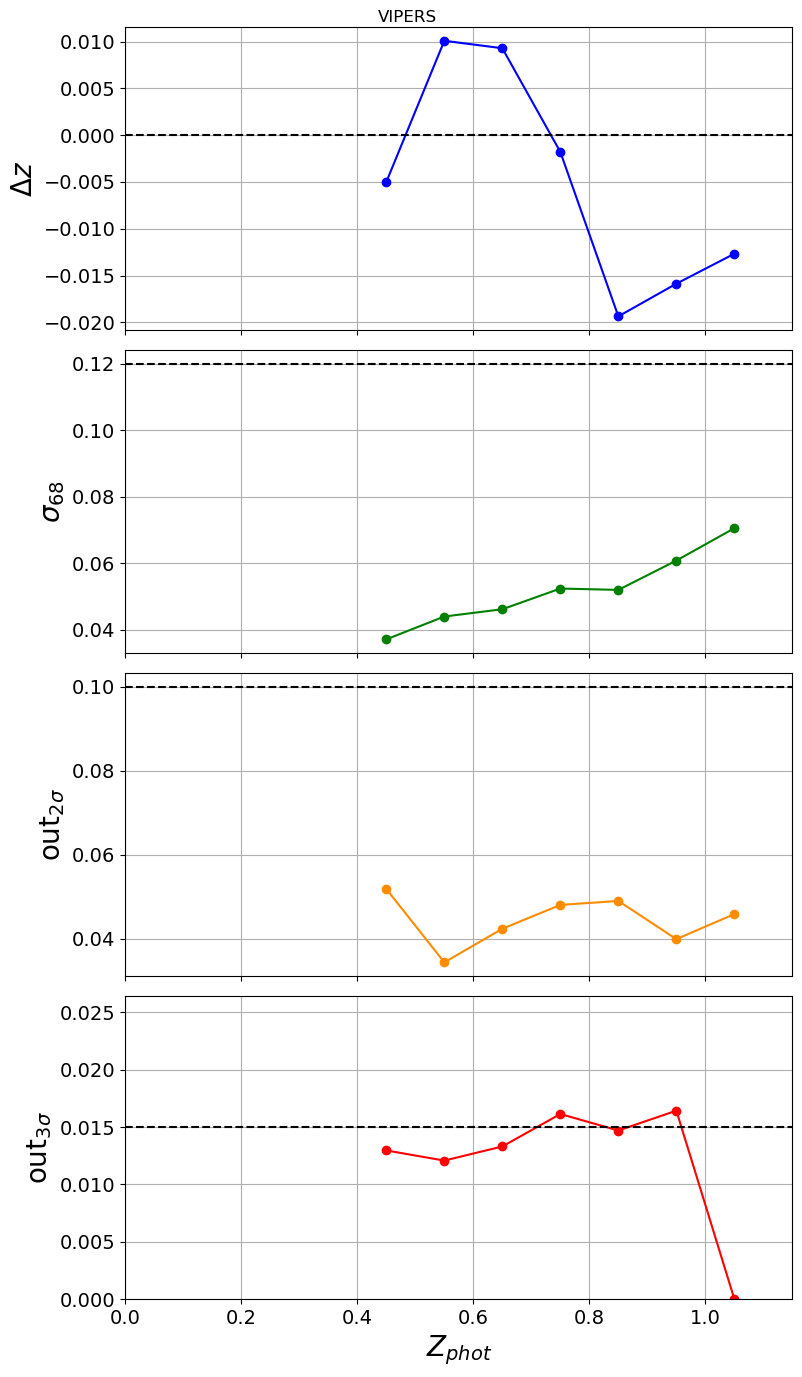

In [39]:
plot_metrics(zspec_vipers,zphot_vipers,1.2,initial=0.4,title='VIPERS')

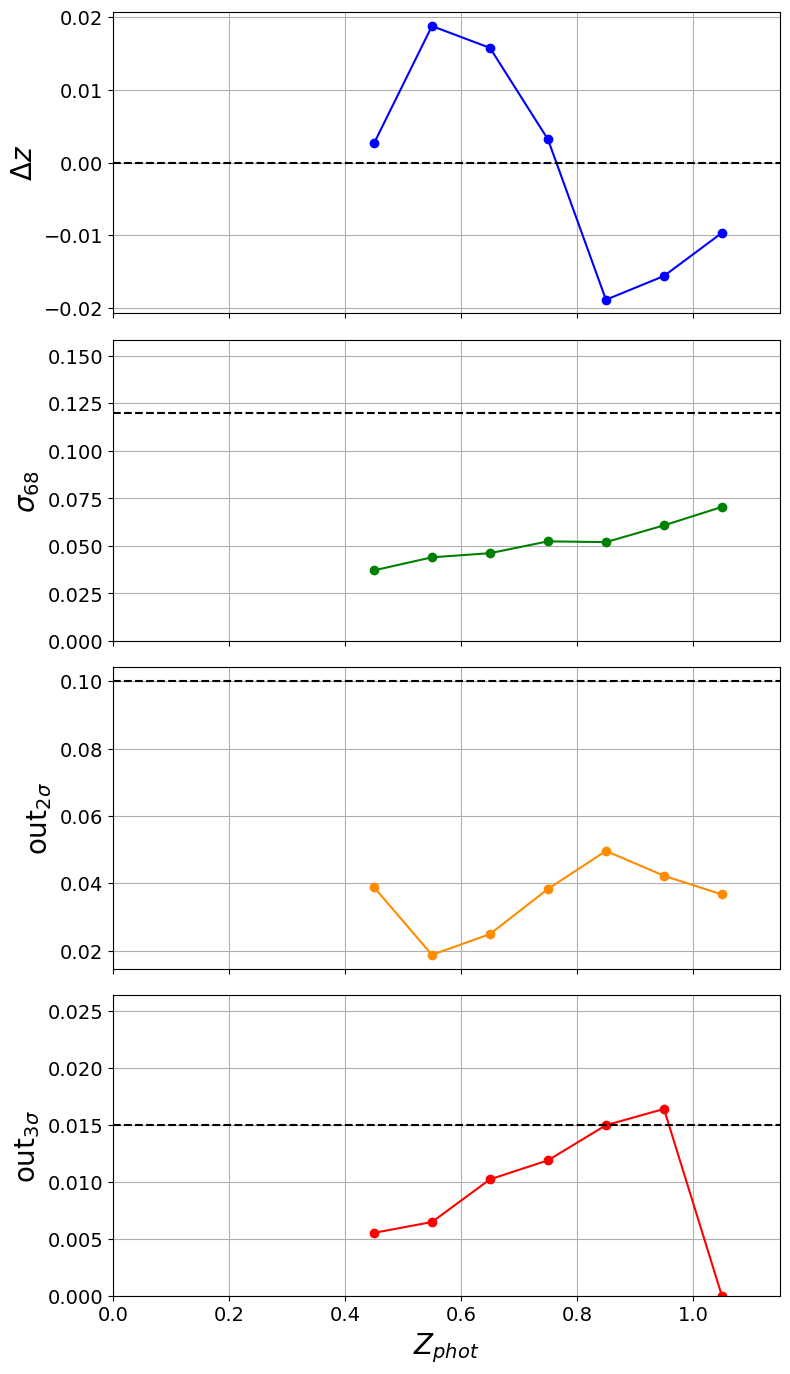

In [40]:
plot_metrics_weight(zspec_vipers,zphot_vipers,w_vipers,1.2,initial=0.4)

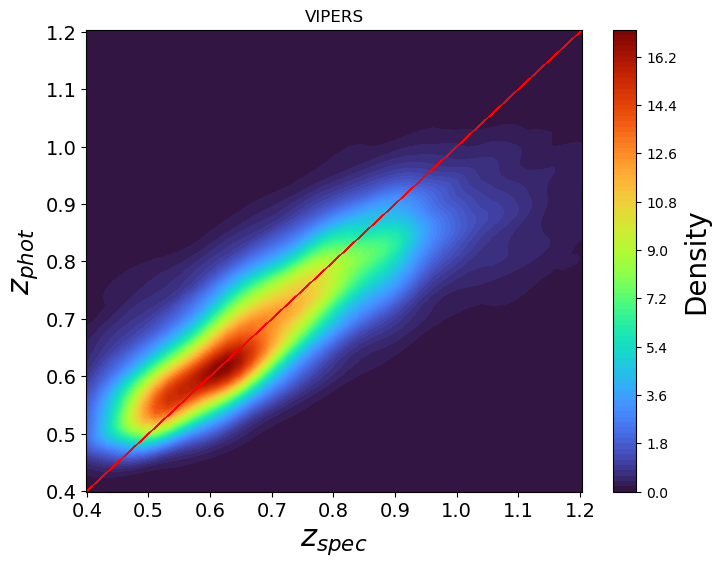

In [41]:
plot_scatter(zspec_vipers,zphot_vipers,'VIPERS')

In [42]:
metrics(zspec_vipers,zphot_vipers)

Mean   : 0.001117437497174375

Sigma  : 0.10365865821205082

Sigma68: 0.04841471334947155

Out_3  : 0.0160495501604955

Out_2  : 0.04548126045481261


In [43]:
metrics_weight(zspec_vipers,zphot_vipers,w_vipers)

Mean   : 0.007657023353883529

Sigma  : 0.11388857482195681

Sigma68: 0.04841471334947155

Out_3  : 0.0127040101270401

Out_2  : 0.036258420362584205


## Gama results

In [44]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df_gama = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/results/results.control_GAMA.0.mlz',names = column_names, header = None, skiprows =1, sep =' ')

zspec_gama=df_gama['ztrue']
zphot_gama = df_gama['zmean1']

Checking the percentage of redshift after a vulue. (Choose the max of plot_metrics)

In [45]:
len(zspec_gama[zspec_gama>0.5])/len(zspec_gama)

0.0030011542901115813

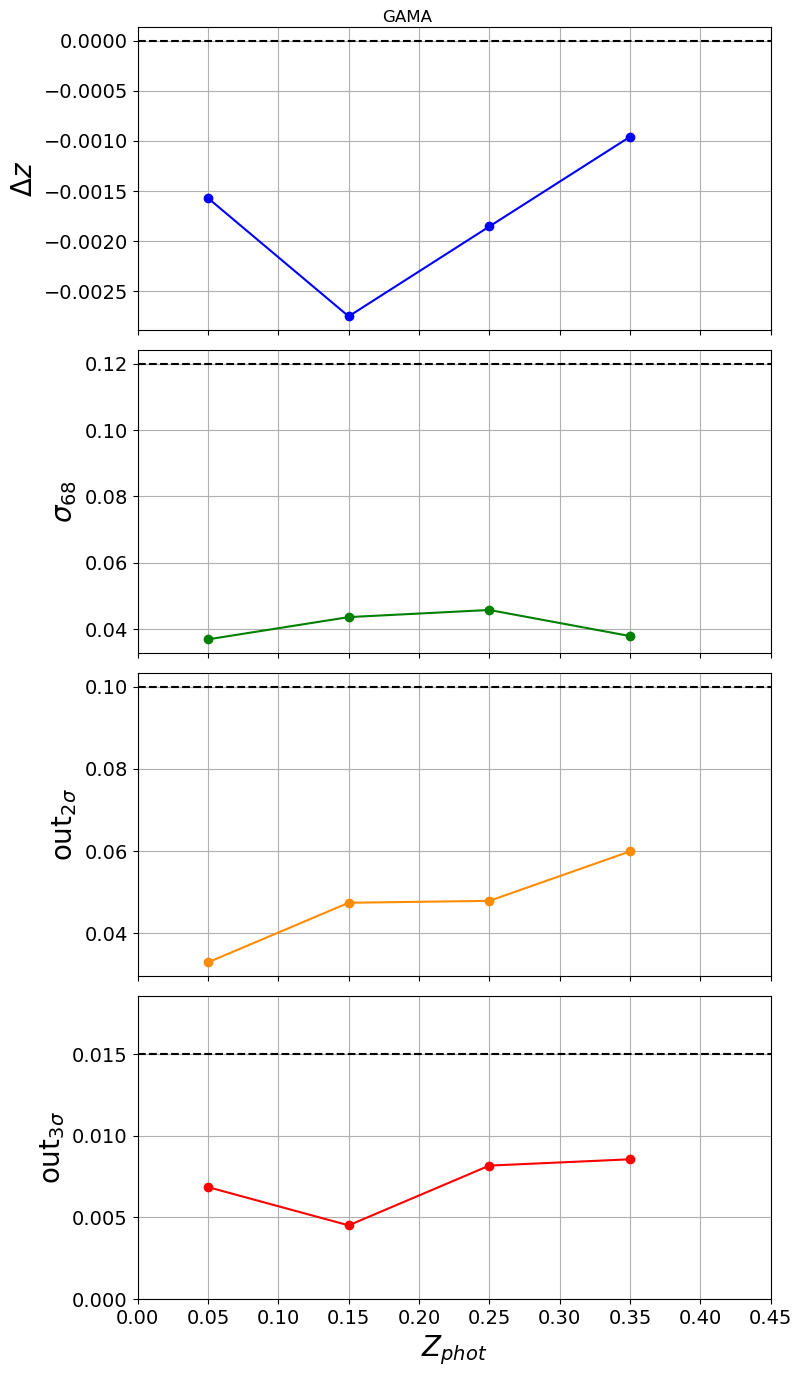

In [46]:
plot_metrics(zspec_gama,zphot_gama,0.5,initial=0,title='GAMA')

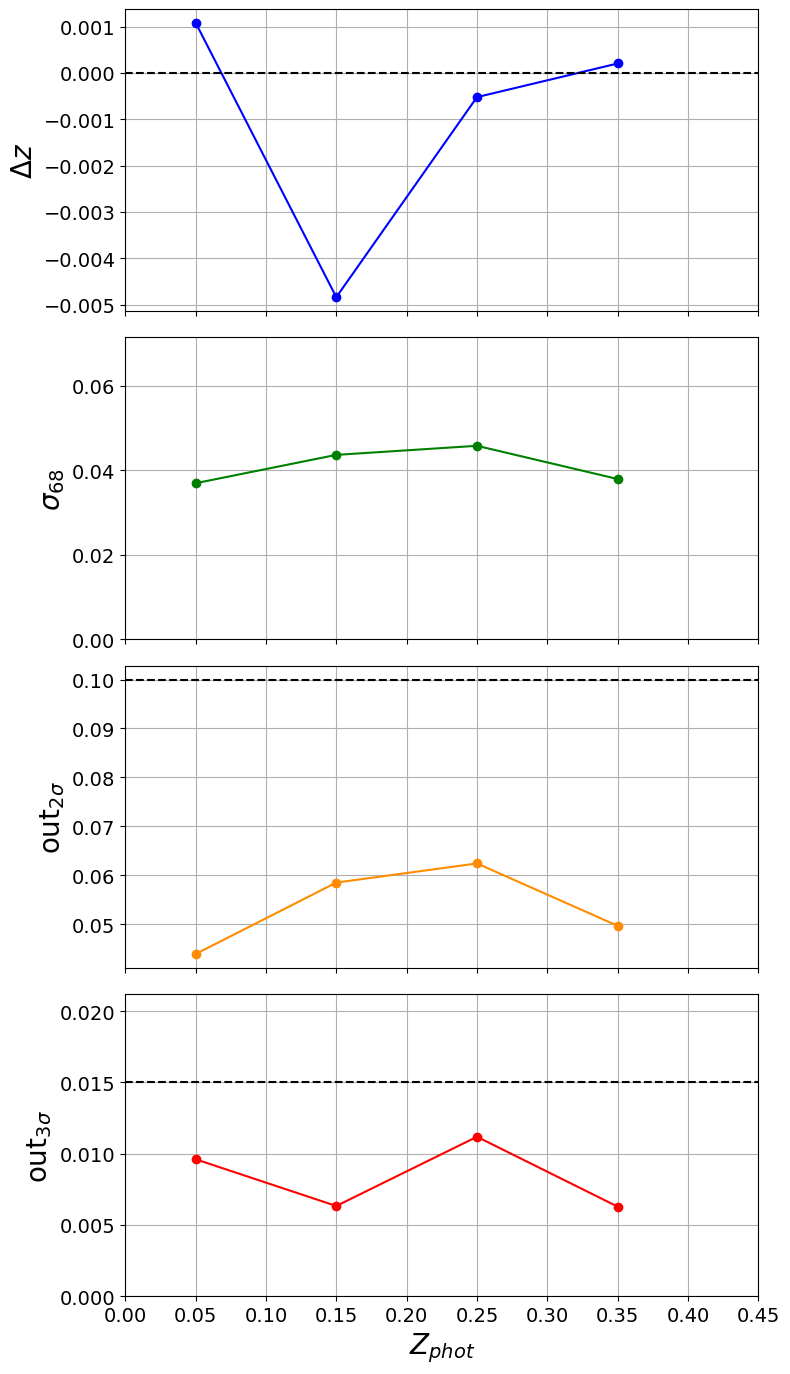

In [47]:
plot_metrics_weight(zspec_gama,zphot_gama,w_gama,0.5)

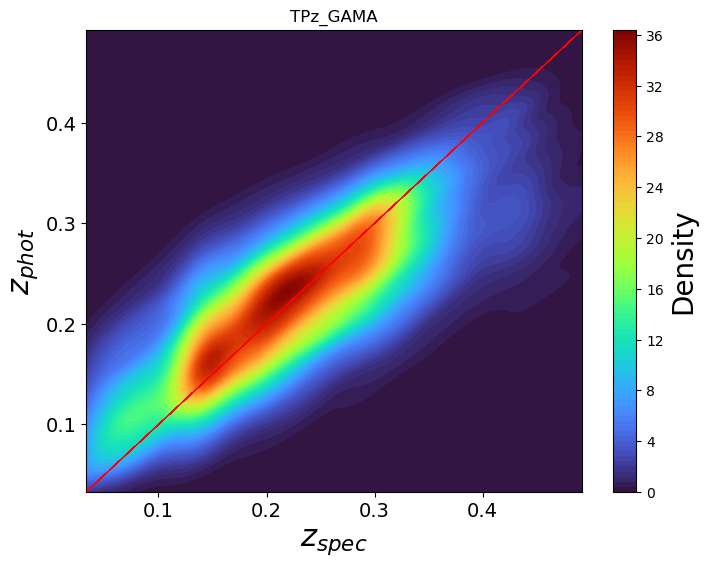

In [48]:
plot_scatter(zspec_gama,zphot_gama,title='TPz_GAMA')

In [49]:
metrics(zspec_gama,zphot_gama)

Mean   : -0.001978838014621008

Sigma  : 0.05795011260240415

Sigma68: 0.04294310722100657

Out_3  : 0.007464409388226241

Out_2  : 0.05055790688726433


In [50]:
metrics_weight(zspec_gama,zphot_gama,w_gama)

Mean   : -0.0015702620781193166

Sigma  : 0.052741079558717915

Sigma68: 0.04294310722100657

Out_3  : 0.012466333205078877

Out_2  : 0.0706425548287803


## Combining both results

In [51]:
zphot = pd.concat([zphot_gama,zphot_vipers],axis=0)
zspec = pd.concat([zspec_gama,zspec_vipers],axis=0)
w = pd.concat([w_gama,w_vipers],axis=0)

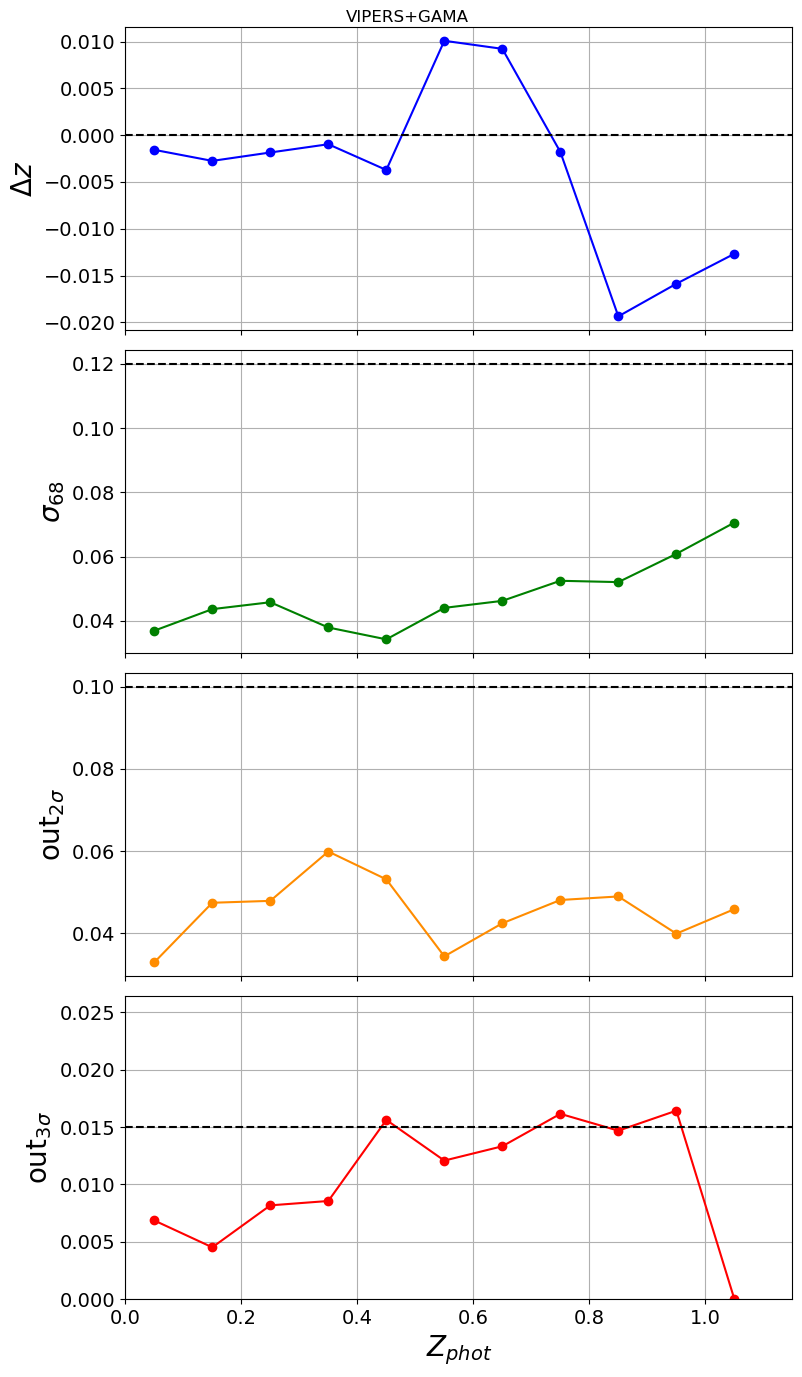

In [52]:
plot_metrics(zspec,zphot,1.2,title='VIPERS+GAMA')

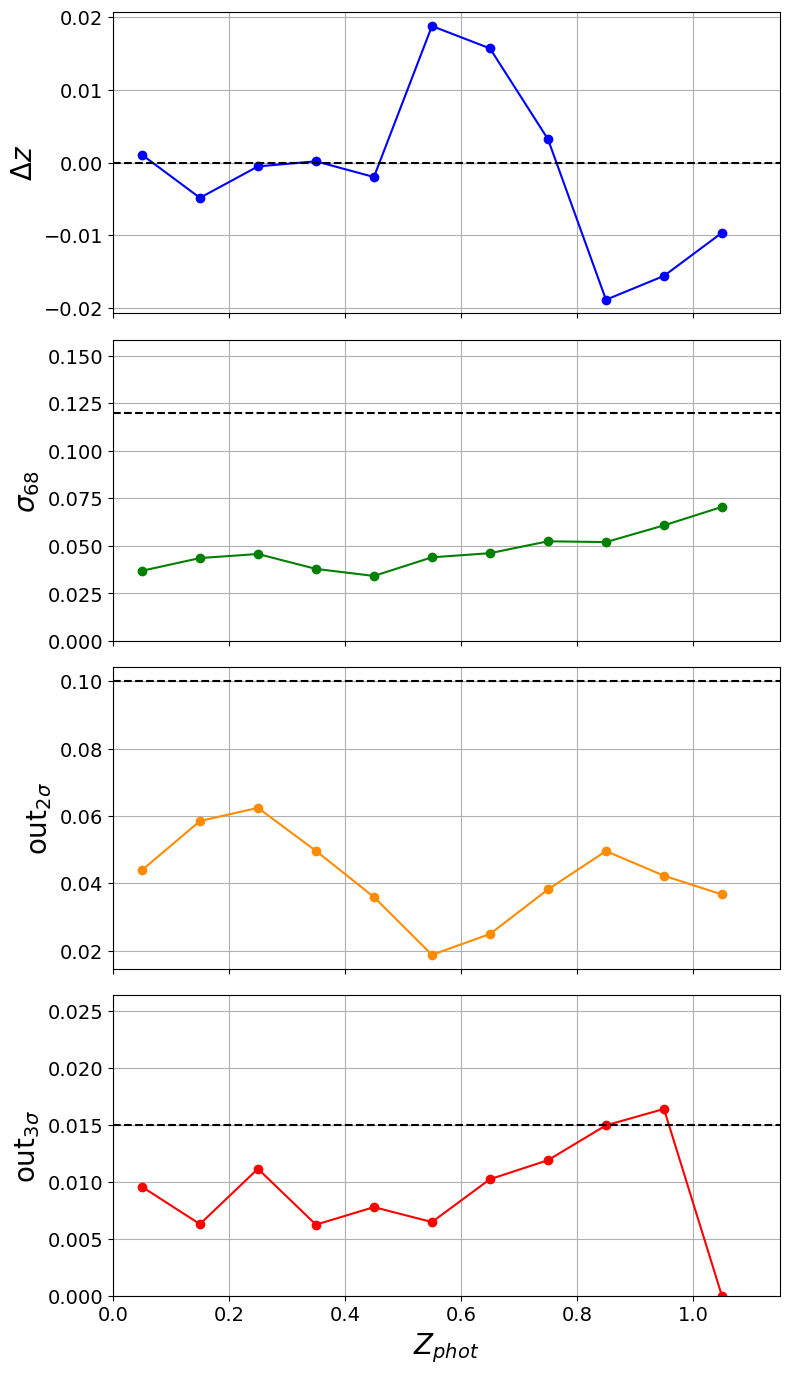

In [53]:
plot_metrics_weight(zspec,zphot,w,1.2)

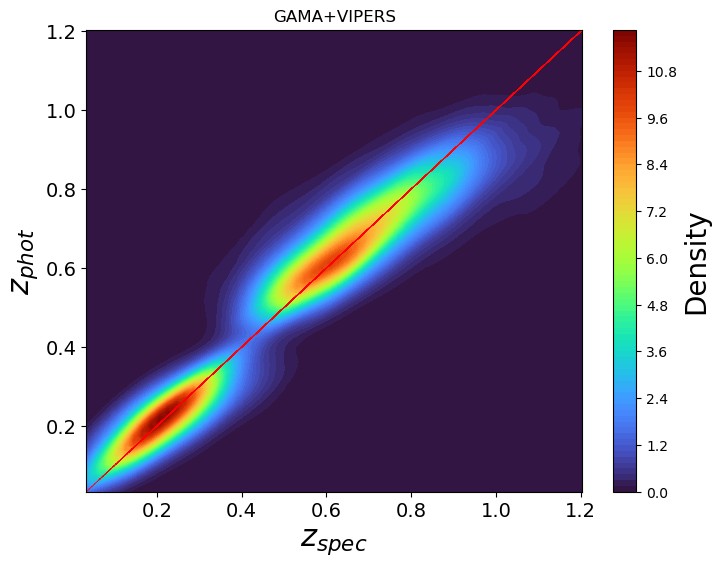

In [54]:
plot_scatter(zspec,zphot,'GAMA+VIPERS')

In [55]:
metrics(zspec,zphot)

Mean   : -2.843310360539966e-05

Sigma  : 0.08951874329143668

Sigma68: 0.04625860989355041

Out_3  : 0.015321524178390385

Out_2  : 0.044540639061343056


In [56]:
metrics_weight(zspec,zphot,w)

Mean   : 0.0022154353071178385

Sigma  : 0.08356122268161506

Sigma68: 0.04625860989355041

Out_3  : 0.018397220481859086

Out_2  : 0.05251466651478043
